In [4]:
# load the pridict, deepprime and conventional ML models
import os
import sys
import numpy as np
import pandas as pd
import pickle
import torch
import skorch

from models.deepprime import predict_deep_prime
from models.pridict import predict_pridict
from models.conventional_ml_models import MLP
from collections import defaultdict

# suppress warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

dataf = 'pd-adv-pe2'

data_dp = f'dp-{dataf}.csv'
data_pd = f'pd-{dataf}.csv'

prediction_pd, _ = predict_pridict(data_pd, num_features=24, device='cuda' if torch.cuda.is_available() else 'cpu', dropout=0)
prediction_dp, _ = predict_deep_prime(data_dp, num_features=24, dropout=0)

prediction_mlp = defaultdict(list)
prediction_rf = defaultdict(list)
prediction_xgb = defaultdict(list)
prediction_ridge = defaultdict(list)
prediction_lasso = defaultdict(list)

data = pd.read_csv(f'models/data/conventional-ml/ml-{dataf}.csv')
for i in range(5):
    fold = i + 1
    # load the test data
    X_test = data[data['fold'] == i].iloc[:, :24].values
    y_test = data[data['fold'] == i].iloc[:, -2].values
    # load the models
    with open(f'models/trained-models/conventional-ml/random_forest-{dataf}-fold-{fold}.pkl', 'rb') as f:
        rf = pickle.load(f)
    with open(f'models/trained-models/conventional-ml/xgboost-{dataf}-fold-{fold}.pkl', 'rb') as f:
        xgb = pickle.load(f)
    with open(f'models/trained-models/conventional-ml/ridge-{dataf}-fold-{fold}.pkl', 'rb') as f:
        ridge = pickle.load(f)
    with open(f'models/trained-models/conventional-ml/lasso-{dataf}-fold-{fold}.pkl', 'rb') as f:
        lasso = pickle.load(f)
    mlp_model = skorch.NeuralNetRegressor(
            module=MLP,
            device='cuda',
            module__hidden_layer_sizes = (64, 64,),
        )
    mlp_model.initialize()
    mlp_model.load_params(f_params=f'models/trained-models/conventional-ml/mlp-{dataf}-fold-{fold}.pkl')

    prediction_rf[i] = rf.predict(X_test)
    prediction_xgb[i] = xgb.predict(X_test)
    prediction_ridge[i] = ridge.predict(X_test)
    prediction_lasso[i] = lasso.predict(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    prediction_mlp[i] = mlp_model.predict(X_test)



Predicting PRIDICT model...
Using device: cuda
Predicting fold 1...
Fold 1 RMSE: 2.245405767613064
Fold 1 Pearson: 0.5189383968122246, Spearman: 0.5681768754106908
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 2...
Fold 2 RMSE: 2.2602036596854016
Fold 2 Pearson: 0.5651511616712773, Spearman: 0.5630693239682992
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 3...
Fold 3 RMSE: 2.385514990192854
Fold 3 Pearson: 0.5386633153016946, Spearman: 0.5398554677366946
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 4...
Fold 4 RMSE: 2.6371949617924124
Fold 4 Pearson: 0.5374761446376096, Spearman: 0.5218469383367739
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
Predicting fold 5...
Fold 5 RMSE: 2.337491466200188
Fold 5 Pearson: 0.5585159439629288, Spearman: 0.5535931778283325
99
Fold 1 Pearson: 0.3723004065445481, Spearman: 0.503

Concatenated
DeepPrime: 6.036067139455133
Pridict: 5.65300572836892
Random Forest: 6.668648160397283
XGBoost: 6.896729587515746
Ridge: 6.86331455775152
Lasso: 6.857583099074541
MLP: 6.4516748464978635
DeepPrime: 0.495454794035593
Pridict: 0.5408838687304676
Random Forest: 0.40765121259734566
XGBoost: 0.41548209687885274
Ridge: 0.3745759984010409
Lasso: 0.3755336056937257
MLP: 0.4388315500199624


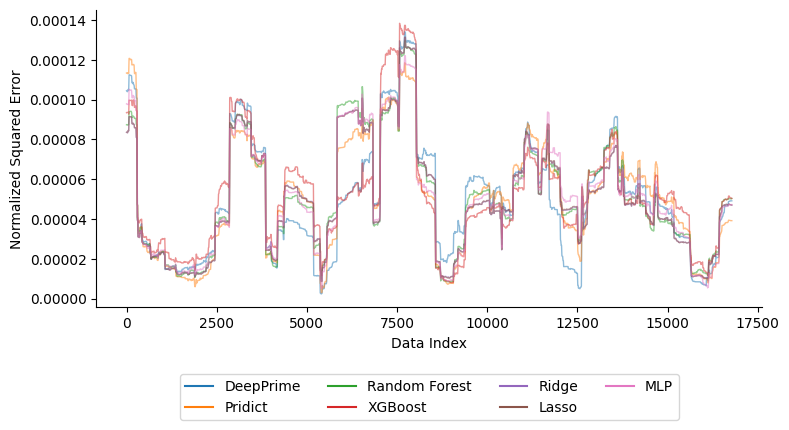

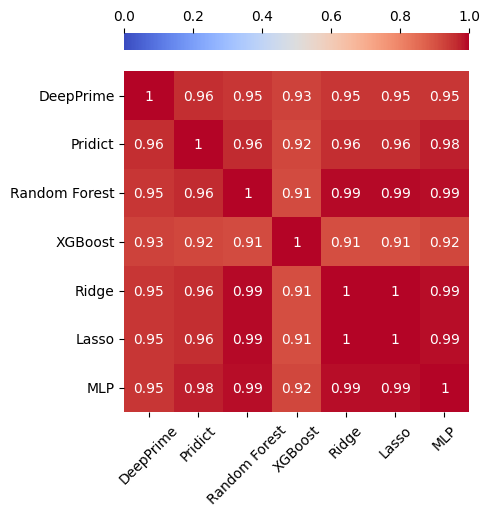

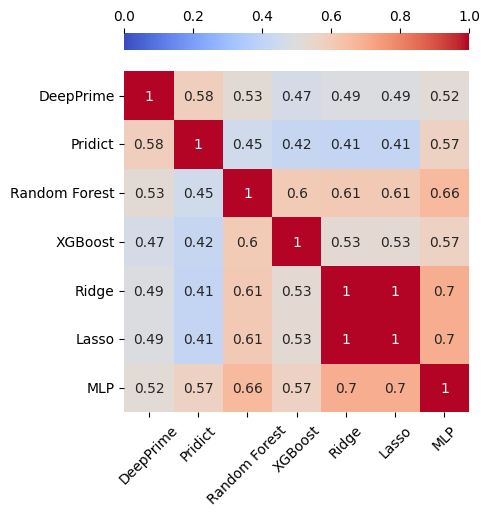

In [5]:
# concatenate the predictions for each fold into a single array
prediction_pd_list = np.concatenate([prediction_pd[fold].flatten() for fold in range(5)])
prediction_dp_list = np.concatenate([prediction_dp[fold].flatten() for fold in range(5)])
prediction_rf_list = np.concatenate([prediction_rf[fold] for fold in range(5)])
prediction_xgb_list = np.concatenate([prediction_xgb[fold] for fold in range(5)])
prediction_ridge_list = np.concatenate([prediction_ridge[fold] for fold in range(5)])
prediction_lasso_list = np.concatenate([prediction_lasso[fold] for fold in range(5)])
prediction_mlp_list = np.concatenate([prediction_mlp[fold].flatten() for fold in range(5)])

print('Concatenated')

# calculate the squared error from the predictions
y_test = np.concatenate([data[data['fold'] == i].iloc[:, -2].values for i in range(5)])
mse_dp = (y_test - prediction_dp_list)**2
mse_pd = (y_test - prediction_pd_list)**2
mse_rf = (y_test - prediction_rf_list)**2
mse_xgb = (y_test - prediction_xgb_list)**2
mse_ridge = (y_test - prediction_ridge_list)**2
mse_lasso = (y_test - prediction_lasso_list)**2
mse_mlp = (y_test - prediction_mlp_list)**2

# print the mse of each model
print('DeepPrime:', np.sum(mse_dp) / len(mse_dp))
print('Pridict:', np.sum(mse_pd) / len(mse_pd))
print('Random Forest:', np.sum(mse_rf) / len(mse_rf))
print('XGBoost:', np.sum(mse_xgb) / len(mse_xgb))
print('Ridge:', np.sum(mse_ridge) / len(mse_ridge))
print('Lasso:', np.sum(mse_lasso) / len(mse_lasso))
print('MLP:', np.sum(mse_mlp) / len(mse_mlp))

# print the pearson correlation coefficient between model predictions and true values
from scipy.stats import pearsonr
print('DeepPrime:', pearsonr(y_test, prediction_dp_list)[0])
print('Pridict:', pearsonr(y_test, prediction_pd_list)[0])
print('Random Forest:', pearsonr(y_test, prediction_rf_list)[0])
print('XGBoost:', pearsonr(y_test, prediction_xgb_list)[0])
print('Ridge:', pearsonr(y_test, prediction_ridge_list)[0])
print('Lasso:', pearsonr(y_test, prediction_lasso_list)[0])
print('MLP:', pearsonr(y_test, prediction_mlp_list)[0])

# normalize the squared error
mse_dp = mse_dp / np.sum(mse_dp)
mse_pd = mse_pd / np.sum(mse_pd)
mse_rf = mse_rf / np.sum(mse_rf)
mse_xgb = mse_xgb / np.sum(mse_xgb)
mse_ridge = mse_ridge / np.sum(mse_ridge)
mse_lasso = mse_lasso / np.sum(mse_lasso)
mse_mlp = mse_mlp / np.sum(mse_mlp)


# plot the smoothened error using a moving average
import matplotlib.pyplot as plt
import seaborn as sns

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

# downsample the data to improve visualization
x = np.arange(len(mse_dp))
downsample = 10
x = x[::downsample]
mse_dp = mse_dp[::downsample]
mse_pd = mse_pd[::downsample]
mse_rf = mse_rf[::downsample]
mse_xgb = mse_xgb[::downsample]
mse_ridge = mse_ridge[::downsample]
mse_lasso = mse_lasso[::downsample]
mse_mlp = mse_mlp[::downsample]

fig, axes = plt.subplots(1, 1, figsize=(8, 4.5))
window = 100
# update x to match the length of the moving average
x = x[:-(window - 1)]
axes.plot(x, moving_average(mse_dp, window), label='DeepPrime')
axes.plot(x, moving_average(mse_pd, window), label='Pridict')
axes.plot(x, moving_average(mse_rf, window), label='Random Forest')
axes.plot(x, moving_average(mse_xgb, window), label='XGBoost')
axes.plot(x, moving_average(mse_ridge, window), label='Ridge')
axes.plot(x, moving_average(mse_lasso, window), label='Lasso')
axes.plot(x, moving_average(mse_mlp, window), label='MLP')
# legend of two rows
axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=4)

# set x and y labels
axes.set_xlabel('Data Index')
axes.set_ylabel('Normalized Squared Error')


# reduce thickness and alpha of the lines
for line in plt.gca().lines:
    line.set_linewidth(1)
    line.set_alpha(0.5)

# remove the top and right spines
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join('dissertation', 'figures', f'error_comparison_{dataf}.png'), dpi=300)

# calculate the pearson correlation coefficient between each error and plot in heatmap
from scipy.stats import pearsonr, spearmanr

mse_dict = {
    'DeepPrime': mse_dp,
    'Pridict': mse_pd,
    'Random Forest': mse_rf,
    'XGBoost': mse_xgb,
    'Ridge': mse_ridge,
    'Lasso': mse_lasso,
    'MLP': mse_mlp,
}

fig, axes = plt.subplots(1, 1, figsize=(5, 5.5))

correlation_matrix = np.zeros((len(mse_dict), len(mse_dict)))
for i, mse in enumerate(mse_dict.values()):
    for j, mse2 in enumerate(mse_dict.values()):
        correlation_matrix[i, j] = pearsonr(mse, mse2)[0]

# heat map with cbar in range 0 to 1, horizontal and on top of the plot
sns.heatmap(correlation_matrix, ax=axes, cbar_kws={'location': 'top', 'pad': 0.05}, vmin=0, vmax=1, cmap='coolwarm', annot=True)

# set cbar limit
# cbar = axes.collections[0].colorbar
# cbar.set_ticks([0, 0.5, 1])
plt.xticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=45)
plt.yticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=0)

plt.tight_layout()
plt.savefig(os.path.join('dissertation', 'figures', f'error_correlation_{dataf}_pearson.png'), dpi=300)

fig, axes = plt.subplots(1, 1, figsize=(5, 5.5))

correlation_matrix = np.zeros((len(mse_dict), len(mse_dict)))
for i, mse in enumerate(mse_dict.values()):
    for j, mse2 in enumerate(mse_dict.values()):
        # spearman correlation
        correlation_matrix[i, j] = spearmanr(mse, mse2)[0]

# heat map with cbar in range 0 to 1, horizontal and on top of the plot
sns.heatmap(correlation_matrix, ax=axes, cbar_kws={'location': 'top', 'pad': 0.05}, vmin=0, vmax=1, cmap='coolwarm', annot=True)

plt.xticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=45)
plt.yticks(np.arange(len(mse_dict)) + 0.5, mse_dict.keys(), rotation=0)

# save the plots
plt.tight_layout()
plt.savefig(os.path.join('dissertation', 'figures', f'error_correlation_{dataf}_spearman.png'), dpi=300)